In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


In [3]:
!python3 -m pip install python-dotenv
!python3 -m pip install wandb
!pip install loguru


In [ ]:
!wandb login e7c8c5e645594de1e62241483f608a2c4a485fd5


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN


# internal imports

In [11]:
# from triagerx.dataset.processor import DatasetProcessor
# from triagerx.model.roberta_cnn import RobertaCNNClassifier
# from triagerx.model.roberta_fcn import RobertaFCNClassifier
# from triagerx.trainer.train_config import TrainConfig
# from triagerx.trainer.model_trainer import ModelTrainer
# from triagerx.evaluation.evaluator import Evaluator
# from triagerx.dataset.triage_dataset import TriageDataset

## DatasetProcessor

In [12]:
# from triagerx.dataset.processor import DatasetProcessor

import pandas as pd
from loguru import logger


class DatasetProcessor:
    @staticmethod
    def load_dataframe(path: str) -> pd.DataFrame:
        logger.debug(f"Loading dataframe: {path}")
        return pd.read_csv(path)

    @staticmethod
    def clean_data(df: pd.DataFrame) -> pd.DataFrame:
        logger.debug("Cleaning dataset...")
        df["text"] = df["text"].str.replace(
            "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
            " ",
        )
        df["text"] = df["text"].str.replace(" +", " ", regex=True)

        return df

    @staticmethod
    def prepare_dataframe(df: pd.DataFrame, sample_threshold: int = 0) -> pd.DataFrame:
        logger.debug(
            f"Filtering developers based on minimum contribution: {sample_threshold}..."
        )
        df = df[df["assignees"].notna()]
        developers = df["assignees"].value_counts()
        filtered_developers = developers.index[developers >= sample_threshold]
        df = df[df["assignees"].isin(filtered_developers)]

        logger.debug("Generating 'text' field...")
        df["text"] = df.apply(
            lambda x: "Title: "
            + str(x["issue_title"])
            + "\nLabels: "
            + str(x["labels"])
            + "\nDescription: "
            + str(x["issue_body"]),
            axis=1,
        )

        min_length = 15
        logger.debug(f"Dropping rows with 'text' length < {min_length}...")
        df = df[df["text"].str.len().gt(min_length)]

        df["owner_id"] = pd.factorize(df["assignees"])[0]

        return df

    @staticmethod
    def process_dataset(path: str, sample_threshold: int = 0) -> pd.DataFrame:
        df = DatasetProcessor.load_dataframe(path=path)
        df = DatasetProcessor.prepare_dataframe(
            df=df, sample_threshold=sample_threshold
        )
        df = DatasetProcessor.clean_data(df=df)

        return df


## RobertaCNNClassifier

In [13]:
# from triagerx.model.roberta_cnn import RobertaCNNClassifier

import torch
from torch import nn
import torch.nn.functional as F
from transformers import RobertaModel, RobertaTokenizer


class RobertaCNNClassifier(nn.Module):
    def __init__(
        self, model_name: str, output_size, embed_size=1024, dropout=0.1
    ) -> None:
        super().__init__()
        self.base_model = RobertaModel.from_pretrained(
            model_name, output_hidden_states=True
        )
        filter_sizes = [3, 4, 5, 6]
        num_filters = 256
        self._tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self._convs = nn.ModuleList(
            [nn.Conv2d(4, num_filters, (K, embed_size)) for K in filter_sizes]
        )
        self._dropout = nn.Dropout(dropout)
        self._fc = nn.Linear(len(filter_sizes) * num_filters, output_size)
        self._relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        x = self.base_model(input_ids, attention_mask=attention_mask)[2][-4:]
        x = torch.stack(x, dim=1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self._convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self._dropout(x)
        logit = self._fc(x)

        return logit

    def tokenizer(self) -> RobertaTokenizer:
        return self._tokenizer


## RobertaFCNClassifier

In [14]:
# from triagerx.model.roberta_fcn import RobertaFCNClassifier

import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer


class RobertaFCNClassifier(nn.Module):
    def __init__(
        self,
        model_name: str,
        output_size,
        embed_size=1024,
        dropout=0.1
    ) -> None:
        super().__init__()
        self.base = AutoModel.from_pretrained(model_name)
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.linear = nn.Linear(embed_size, embed_size // 2)
        self.linear2 = nn.Linear(embed_size // 2, output_size)
        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, input_id, attention_mask):
        _, pooler_out = self.base(
            input_ids=input_id, attention_mask=attention_mask, return_dict=False
        )
        pooler_out = self.relu(pooler_out)
        drop_out = self.dropout(pooler_out)
        linear_out = self.linear(drop_out)
        linear_out = self.relu(linear_out)
        drop_out = self.dropout2(linear_out)
        linear_out = self.linear2(drop_out)

        return linear_out

    def tokenizer(self) -> PreTrainedTokenizer:
        return self._tokenizer

## TrainConfig

In [15]:
# from triagerx.trainer.train_config import TrainConfig

from typing import Any, Dict, Optional

import pandas as pd
from pydantic import BaseModel
from torch import nn
from torch.optim import Optimizer
from torch.utils.data.sampler import Sampler


class TrainConfig(BaseModel):
    optimizer: Optimizer
    criterion: nn.Module
    train_dataset: pd.DataFrame
    validation_dataset: pd.DataFrame
    learning_rate: float
    batch_size: int
    epochs: int
    output_file: str
    scheduler: Optional[Any] = None
    sampler: Optional[Sampler] = None
    wandb: Optional[Dict] = None

    class Config:
        arbitrary_types_allowed = True


## ModelTrainer

In [16]:
# from triagerx.trainer.model_trainer import ModelTrainer

import numpy as np
import torch
from loguru import logger
from sklearn.metrics import precision_recall_fscore_support
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import wandb
# from triagerx.dataset.triage_dataset import TriageDataset
# from triagerx.trainer.train_config import TrainConfig


class ModelTrainer:
    def __init__(self, config: TrainConfig):
        self._config = config

    def _init_wandb(self):
        wandb.init(**self._config.wandb)

    def train(self, model: nn.Module):
        tokenizer = model.tokenizer()
        criterion = self._config.criterion
        optimizer = self._config.optimizer
        train_data = self._config.train_dataset
        validation_data = self._config.validation_dataset
        sampler = self._config.sampler

        train = TriageDataset(train_data, tokenizer)
        val = TriageDataset(validation_data, tokenizer)

        if self._config.wandb:
            logger.debug("Initializing wandb...")
            self._init_wandb()

        train_dataloader = DataLoader(
            dataset=train,
            batch_size=self._config.batch_size,
            shuffle=False if sampler else True,
            sampler=sampler,
        )
        val_dataloader = DataLoader(val, batch_size=self._config.batch_size)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        best_loss = float("inf")

        if torch.cuda.is_available():
            logger.debug(f"Selected compute device: {device}")
            model = model.cuda()
            criterion = criterion.cuda()

        for epoch_num in range(self._config.epochs):
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input["attention_mask"].to(device)
                input_id = train_input["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            all_preds = []
            all_labels = []

            with torch.no_grad():

                for val_input, val_label in val_dataloader:
                    val_label = val_label.to(device)
                    mask = val_input["attention_mask"].to(device)
                    input_id = val_input["input_ids"].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()

                    all_preds.append(output.argmax(dim=1).cpu().numpy())
                    all_labels.append(val_label.cpu().numpy())

                    total_acc_val += acc

            all_preds = np.concatenate(all_preds)
            all_labels = np.concatenate(all_labels)

            precision, recall, f1_score, _ = precision_recall_fscore_support(
                all_preds, all_labels, average="macro"
            )

            self._log_step(
                epoch_num,
                total_acc_train,
                total_acc_val,
                total_loss_train,
                total_loss_val,
                precision,
                recall,
                f1_score,
                train_data,
                validation_data,
            )

            val_loss = total_loss_val / len(validation_data)

            if self._config.scheduler:
                self._config.scheduler.step(val_loss)

            if val_loss < best_loss:
                logger.success("Found new best model. Saving weights...")
                torch.save(model.state_dict(), self._config.output_file)
                best_loss = val_loss

        if self._config.wandb:
            wandb.finish()

    def _log_step(
        self,
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        train_data,
        validation_data,
    ):
        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                    | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                    | Val Loss: {total_loss_val / len(validation_data): .3f} \
                    | Val Accuracy: {total_acc_val / len(validation_data): .3f} \
                    | Precision: {precision: .3f} \
                    | Recall: {recall: .3f} \
                    | F1-score: {f1_score: .3f}"

        logger.info(log)

        if self._config.wandb:
            wandb.log(
                {
                    "train_acc": total_acc_train / len(train_data),
                    "train_loss": total_loss_train / len(train_data),
                    "val_acc": total_acc_val / len(validation_data),
                    "val_loss": total_loss_val / len(validation_data),
                    "precision": precision,
                    "recall": recall,
                    "f1-score": f1_score,
                }
            )


## Evaluator

In [17]:
# from triagerx.evaluation.evaluator import Evaluator

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from loguru import logger
from sklearn.metrics import top_k_accuracy_score


class Evaluator:
    def calculate_top_k_accuray(
        self, model: nn.Module, k: int, X_test: pd.DataFrame, y_test: np.array
    ):
        has_cuda = torch.cuda.is_available()

        if has_cuda:
            model = model.cuda()

        tokenizer = model.tokenizer()

        y_preds = []

        logger.debug("Calculating predications...")
        for i in range(len(X_test)):
            dx = X_test.iloc[i]

            data = tokenizer(
                dx["text"], padding="max_length", max_length=512, truncation=True
            )
            ids, mask = data["input_ids"], data["attention_mask"]

            ids = torch.tensor([ids])
            mask = torch.tensor([mask])

            if has_cuda:
                ids = ids.cuda()
                mask = mask.cuda()

            softmax = nn.Softmax(dim=1)

            with torch.no_grad():
                y_pred = softmax(model(ids, mask))

            y_preds.append(y_pred)

        y_numpy = []

        for y in y_preds:
            y_numpy.append(y.cpu().numpy())

        y_preds = np.array(y_numpy)[:, 0, :]

        logger.debug(f"Calculating top {k} score...")

        score = top_k_accuracy_score(y_test, y_preds, k=k)
        logger.info(f"Top {k} score: {score}")

        return score


## TriageDataset

In [18]:
# from triagerx.dataset.triage_dataset import TriageDataset

import pandas as pd
import numpy as np
from loguru import logger
from torch.utils.data import Dataset

from transformers import PreTrainedTokenizer


class TriageDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        feature: str = "text",
        target: str = "owner_id",
    ):
        logger.debug("Generating torch dataset...")
        self.tokenizer = tokenizer
        self.labels = [label for label in df[target]]
        logger.debug("Tokenizing texts...")
        self.texts = [
            self.tokenizer(
                text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            )
            for text in df[feature]
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


# Load Data

In [19]:
dataset_path = "/content/gdrive/MyDrive/TriagerX/data/openj9/merged_data_dated.csv"


In [20]:
sample_threshold = 5

df = DatasetProcessor.process_dataset(dataset_path, sample_threshold=sample_threshold)


2024-01-27 17:46:46.246 | DEBUG    | __main__:load_dataframe:10 - Loading dataframe: /content/gdrive/MyDrive/TriagerX/data/openj9/merged_data_dated.csv
2024-01-27 17:46:50.693 | DEBUG    | __main__:prepare_dataframe:26 - Filtering developers based on minimum contribution: 5...
2024-01-27 17:46:50.711 | DEBUG    | __main__:prepare_dataframe:34 - Generating 'text' field...
2024-01-27 17:46:50.776 | DEBUG    | __main__:prepare_dataframe:46 - Dropping rows with 'text' length < 15...
2024-01-27 17:46:50.788 | DEBUG    | __main__:clean_data:15 - Cleaning dataset...
<ipython-input-12-87187b0a2771>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text"] = df["text"].str.replace(


<Axes: >

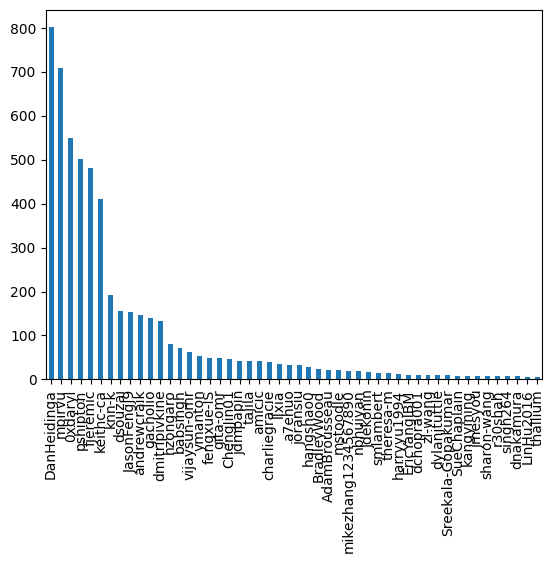

In [21]:
df["assignees"].value_counts().plot(kind="bar")


In [22]:
np.random.seed(42)
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["owner_id"])
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df["owner_id"])

train_df = train_df.fillna("")
valid_df = train_df.fillna("")
test_df = train_df.fillna("")

train_df = train_df.iloc[:, [2,3,4,5,6,7,8,9,12,13]]
valid_df = valid_df.iloc[:, [2,3,4,5,6,7,8,9,12,13]]
test_df = test_df.iloc[:, [2,3,4,5,6,7,8,9,12,13]]


In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer()
# vectorizer.fit(train_df.iloc[:, [2]] .values.ravel())
# X_train=vectorizer.transform(train_df.iloc[:, [2]] .values.ravel())
# X_test=vectorizer.transform(test_df.iloc[:, [2]] .values.ravel())
# X_train
# # X_train=X_train.toarray()
# # X_test=X_test.toarray()

In [ ]:
# sme = SMOTEENN(random_state=42)
# smtom = SMOTETomek(random_state=42)
# x_train = pd.DataFrame(X_train)
# X_resampled, y_resampled = smtom.fit_resample(X_train, train_df.loc[:, ["owner_id"]])

In [ ]:
# from collections import Counter
# counter = Counter(train_df.loc[:, :"text"])
# counter

In [23]:
assert len(train_df.owner_id.unique()) == len(test_df.owner_id.unique()) == len(valid_df.owner_id.unique())

# Training

In [24]:
model = RobertaFCNClassifier(
    model_name="roberta-large",
    output_size=len(train_df.owner_id.unique()),
    embed_size=1024
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [25]:
import torch

In [26]:
class_counts = np.bincount(train_df["owner_id"])
num_samples = sum(class_counts)
labels = train_df["owner_id"].to_list() #corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [27]:
torch.cuda.empty_cache()

In [28]:
!nvidia-smi

Sat Jan 27 17:47:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [29]:
learning_rate = 1e-5
epochs = 10
batch_size = 7

# Create sampler
# counts = np.bincount(train_df["owner_id"])
# labels_weights = 1. / counts
# weights = labels_weights[train_df["owner_id"]]
# sampler = WeightedRandomSampler(weights, len(weights))

sampler_name = sampler.__class__.__name__ if sampler else "None"
model_name = model.__class__.__name__

output_file = f"{model_name}_{sample_threshold}_stratify_labels_{sampler_name}"
output_path = f"/content/gdrive/MyDrive/TriagerX/output/{output_file}.pt"

wandb_config = {
        "project": "triagerx",
        "name": f"run_{output_file}",
        "config": {
        "learning_rate": learning_rate,
        "architecture": "Roberta-CNN",
        "dataset": "openj9",
        "epochs": epochs,
    }
}

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=10, factor=0.1, threshold=1e-8)

train_config = TrainConfig(
    optimizer=optimizer,
    criterion=criterion,
    train_dataset=train_df,
    validation_dataset=valid_df,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs,
    output_file=output_path,
    sampler=sampler,
    scheduler=scheduler,
    wandb=wandb_config
)



In [ ]:
trainer = ModelTrainer(train_config)
trainer.train(model=model)

100%|██████████| 519/519 [18:27<00:00,  2.13s/it]
2024-01-27 19:28:25.925 | INFO     | __main__:_log_step:154 - Epochs: 4 | Train Loss:  0.174                     | Train Accuracy:  0.823                     | Val Loss:  0.263                     | Val Accuracy:  0.595                     | Precision:  0.860                     | Recall:  0.707                     | F1-score:  0.753
2024-01-27 19:28:25.928 | SUCCESS  | __main__:train:126 - Found new best model. Saving weights...
 85%|████████▌ | 442/519 [15:41<02:43,  2.12s/it]

In [ ]:
#

# Evaluation

In [ ]:
import torch

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from loguru import logger
from sklearn.metrics import top_k_accuracy_score


class Evaluator:
    def calculate_top_k_accuray(
        self, model: nn.Module, k: int, X_test: pd.DataFrame, y_test: np.array
    ):
        has_cuda = torch.cuda.is_available()

        if has_cuda:
            model = model.cuda()

        tokenizer = model.tokenizer()

        y_preds = []

        logger.debug("Calculating predications...")
        for i in range(len(X_test)):
            dx = X_test.iloc[i]

            data = tokenizer(
                dx["text"], padding="max_length", max_length=512, truncation=True
            )
            ids, mask = data["input_ids"], data["attention_mask"]

            ids = torch.tensor([ids])
            mask = torch.tensor([mask])

            if has_cuda:
                ids = ids.cuda()
                mask = mask.cuda()

            softmax = nn.Softmax(dim=1)

            with torch.no_grad():
                y_pred = softmax(model(ids, mask))

            y_preds.append(y_pred)

        y_numpy = []

        for y in y_preds:
            y_numpy.append(y.cpu().numpy())

        y_preds = np.array(y_numpy)[:, 0, :]

        logger.debug(f"Calculating top {k} score...")

        score = top_k_accuracy_score(y_test, y_preds, k=k)
        logger.info(f"Top {k} score: {score}")

        return score


In [ ]:
model = RobertaCNNClassifier(
    model_name="roberta-base",
    output_size=len(train_df.owner_id.unique()),
    embed_size=768
)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/TriagerX/output/RobertaCNNClassifier_5_stratify_comp-labels_WeightedRandomSampler.pt"))

evaluator = Evaluator()

In [ ]:
# model = RobertaCNNClassifier(
#     model_name="roberta-base",
#     output_size=len(train_df.owner_id.unique()),
#     embed_size=768
# )

model = RobertaFCNClassifier(
    model_name="roberta-large",
    output_size=len(train_df.owner_id.unique()),
    embed_size=1024
)


In [ ]:
MODEL_PATH = "/content/gdrive/MyDrive/TriagerX/output/RobertaFCNClassifier_5_stratify_labels_WeightedRandomSampler_0.pt"

if torch.cuda.is_available():
  model.load_state_dict(torch.load(MODEL_PATH))
else:
  model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))


In [ ]:
evaluator = Evaluator()


In [ ]:
from torch.utils.data import DataLoader

dataset = TriageDataset(test_df, model.tokenizer())

In [ ]:
loader = DataLoader(dataset, 30)

In [ ]:
test_df.head(30)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_preds = []
all_labels = []

if torch.cuda.is_available():
  model = model.cuda()

with torch.no_grad():
    for val_input, val_label in loader:
        val_label = val_label.to(device)
        mask = val_input["attention_mask"].to(device)
        input_id = val_input["input_ids"].squeeze(1).to(device)

        output = model(input_id, mask)
        output = nn.Softmax(dim=1)(output)
        conf, classes = output.topk(10, dim=1)

        print("Pred", output.argmax(dim=1))
        print("Label", val_label.long())
        print("Top 3", classes)

        # batch_loss = criterion(output, val_label.long())
        # total_loss_val += batch_loss.item()

        # acc = (output.argmax(dim=1) == val_label).sum().item()

        # all_preds.append(output.cpu().numpy())
        # all_labels.append(val_label.cpu().numpy())

        # total_acc_val += acc

        break

In [ ]:
import pandas as pd

In [ ]:
x_df = df.copy()

In [ ]:
x_df.head()

In [ ]:
x_df["assignee_w_id"] = x_df.apply(lambda x: str(x["assignees"]) + " " + str(x["owner_id"]), axis=1)

In [ ]:
x_df.head()

In [ ]:
x_df["assignee_w_id"].value_counts()[:20].plot(kind="bar")

In [ ]:
def predict(data, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
      model = model.cuda()

    with torch.no_grad():
        for val_input, val_label in loader:
            val_label = val_label.to(device)
            mask = val_input["attention_mask"].to(device)
            input_id = val_input["input_ids"].squeeze(1).to(device)

            output = model(input_id, mask)
            output = nn.Softmax(dim=1)(output)
            # conf, classes = output.topk(3, dim=1)

            return output.argmax(dim=1)

In [ ]:
test_df.head(30)

In [ ]:
test_df[25:26]

In [ ]:
dx = test_df[25:26]
print(dx["assignees"])

dataset = TriageDataset(dx, model.tokenizer())

predict(dataset, model)

In [ ]:
# all_preds[0]

In [ ]:
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

In [ ]:
# set(all_labels)

In [ ]:
all_preds[0]

In [ ]:
sum(all_preds == all_labels)

In [ ]:
# set(all_labels) - set(all_preds)

In [ ]:
# Top 3 Predictions
evaluator.calculate_top_k_accuray(model, k=3, X_test=test_df, y_test=test_df["owner_id"].to_numpy())

In [ ]:
# Top 5 Predictions
evaluator.calculate_top_k_accuray(model, k=5, X_test=test_df, y_test=test_df["owner_id"].to_numpy())